In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn 

In [2]:
torch.__version__

'2.7.1+cu126'

In [3]:
from pathlib import Path

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} directory does not exist, creating one...")
    image_path.mkdir(parents = True, exist_ok= True)

data/pizza_steak_sushi directory exists


In [ ]:
import requests
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Download the file
response = requests.get(url)
print("Downloading pizza_steak_sushi.zip")

# Save it to a file
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(response.content)


In [21]:
import zipfile

with zipfile.ZipFile(image_path/ "pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)    

Unzipping pizza, steak, sushi data...


In [4]:
import os 
def walk_through_dir(root):
    for root, directory, files in os.walk(top=root, topdown=True):
        print(f"There are {len(directory)} images and {len(files)} inside {root}")

In [5]:
walk_through_dir(image_path)

There are 2 images and 1 inside data/pizza_steak_sushi
There are 3 images and 0 inside data/pizza_steak_sushi/test
There are 0 images and 19 inside data/pizza_steak_sushi/test/steak
There are 0 images and 25 inside data/pizza_steak_sushi/test/pizza
There are 0 images and 31 inside data/pizza_steak_sushi/test/sushi
There are 3 images and 0 inside data/pizza_steak_sushi/train
There are 0 images and 75 inside data/pizza_steak_sushi/train/steak
There are 0 images and 78 inside data/pizza_steak_sushi/train/pizza
There are 0 images and 72 inside data/pizza_steak_sushi/train/sushi


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [9]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)

test_data = ImageFolder(root=test_dir,
                        transform=data_transform,
                        target_transform = None)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             )

In [11]:
img, label = next(iter(train_dataloader))
img.shape, label.shape, img.type, label.type, img.device, label.device

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 <function Tensor.type>,
 <function Tensor.type>,
 device(type='cpu'),
 device(type='cpu'))

In [12]:
class TinyVGG(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, hidden_units=32 ):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*28*28, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features=out_channels)
        )
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.linear(X)
        
        return torch.softmax(X,dim=1)

In [13]:
from torch import device
from helper_functions import accuracy_fn


def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               train_data: torch.utils.data.DataLoader,
               device: torch.device = device,
               ):
    model.to(device)
    train_loss, train_acc = 0,0
    model.train()
    for batch, (X,y) in enumerate(train_data):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true= y, y_pred= y_pred.argmax(dim=1))
        train_loss += loss
        train_acc += acc
        # print(f"Looked at {batch*len(X)}/ {len(train_data.dataset)} samples")
    train_loss /= len(train_data.dataset)
    train_acc /= len(train_data.dataset)
    return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               test_data: torch.utils.data.DataLoader,
               device: torch.device = device,
               ):
    model.to(device)
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_data):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true= y, y_pred= y_pred.argmax(dim=1))
            test_loss += loss
            test_acc += acc
        test_loss /= len(test_data.dataset)
        test_acc /= len(test_data.dataset)
    return test_loss, test_acc

In [16]:
def train(model:torch.nn.Module,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          EPOCHS: int,
          train_data:torch.utils.data.DataLoader,
          test_data:torch.utils.data.DataLoader,
          device: torch.device = device):
    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }
    for epoch in range(EPOCHS):
        train_loss , train_acc = train_step(model=model, 
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            train_data=train_data,
                                            device = device,
                                            )
        test_loss, test_acc = test_step(model= model,
                                        loss_fn=loss_fn,
                                        test_data=test_data,
                                        device= device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
    return results

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
model_0 = TinyVGG(in_channels=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_channels=len(train_data.classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr=0.01)
model_0_results = train(model=model_0, 
                        train_data=train_dataloader,
                        test_data=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        EPOCHS=3,
                        device=device)

Epoch: 1 | train_loss: 0.0390 | train_acc: 1.4306 | test_loss: 0.0439 | test_acc: 1.6894
Epoch: 2 | train_loss: 0.0391 | train_acc: 1.0000 | test_loss: 0.0438 | test_acc: 1.7689
Epoch: 3 | train_loss: 0.0390 | train_acc: 1.4306 | test_loss: 0.0438 | test_acc: 1.7689


In [22]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [24]:
from ast import Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

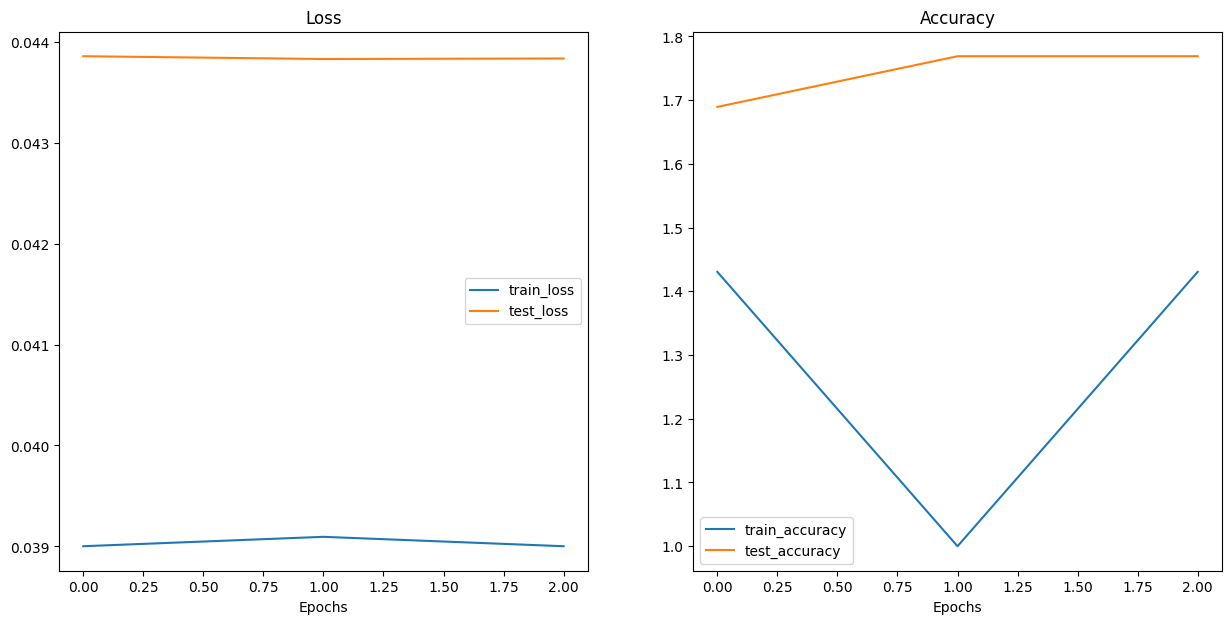

In [25]:
plot_loss_curves(results=model_0_results)

In [51]:
import torchvision
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        transforms: torchvision.transforms.Compose,
                        img_path : str,
                        classes,
                        device : torch.device = device):
    image = Image.open(img_path)
    img = transforms(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        
        y_pred = model(img).to(device)
        y_label = y_pred.argmax(dim=1)
    for i , j in enumerate(classes):
        if i == y_label:
            print(f"detected image is {j}")
    
  
  

In [52]:
pred_and_plot_image(model_0, transforms= data_transform, img_path="/home/owais/PytorchCodes/img/5764.jpg",
                    classes = train_data.class_to_idx,device = device)

detected image is sushi


In [53]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "04_pytorch_custom_dataset_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/04_pytorch_custom_dataset_model.pth
